# Exploratory Data Analysis (EDA) in Python – Step by Step

In this tutorial, we will learn how to perform Exploratory Data Analysis (EDA) using Python.

We will:

- Inspect a dataset that has some cleaning issues
- Clean the data for:
  - Fix data types
  - Handle missing values
  - Fix inconsistent categories
  - Remove duplicates
  - Find outliers using Quantiles
- Explore the data using summary statistics
- Create visualisations:
  - Line chart
  - Bar chart
  - Pie chart


We will use a small **retail sales** example dataset that includes real-world issues such as missing values, inconsistent labels, and outliers.


In [1]:
# Import the main libraries we will use

import pandas as pd          # For data manipulation and analysis
import numpy as np           # For numerical operations
import matplotlib.pyplot as plt   # For charts

# This makes charts appear inside the notebook
%matplotlib inline


In [2]:
# Import the data into Colab
from google.colab import files
uploaded = files.upload()

Saving sample_sales_data.csv to sample_sales_data.csv


In [7]:
# Read the data using Pandas library
df = pd.read_csv("sample_sales_data.csv")
df.head()

,order_id,order_date,product_category,quantity,unit_price,payment_method,city
0,1,2023-02-21,electronics,64,333.00,Card,london
1,2,2023/03/24,Electronics,137,233.43,Card,Birmingham
2,3,2023-02-22,home,2,9.55,Paypal,Birmingham
3,4,2023-01-21,Home,five,12.28,card,birmingham
4,5,2023-02-28,home,64,9.99,Cash,Birmingham


## 2. First look at the data

Before cleaning anything, we should **understand the structure** of the dataset:

- How many rows and columns?
- What are the column names and data types?
- Are there missing values?
- What do some example rows look like?


In [8]:
# Shape: (rows, columns)
df.shape
# Column names and data types
df.info()
# Quick preview of the data
df.head()
# Summary statistics for numeric columns (currently may be incomplete due to wrong data types)
df.describe(include="all")
# Check missing values in each column
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          310 non-null    int64  
 1   order_date        307 non-null    object 
 2   product_category  310 non-null    object 
 3   quantity          233 non-null    object 
 4   unit_price        287 non-null    float64
 5   payment_method    310 non-null    object 
 6   city              310 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 17.1+ KB


,0
order_id,0
order_date,3
product_category,0
quantity,77
unit_price,23
payment_method,0
city,0


## Activity 1

Explain in your word the following python code:

- df.shape
- df.info
- df.head
- df.decsribe(include="all")
- df.isna().sum()

## 3. Data Cleaning

We will clean the data step by step:

1. Fix data types (e.g. numbers stored as text)
2. Convert dates to proper datetime
3. Handle missing values
4. Fix inconsistent category labels
5. Remove duplicates
6. Deal with outliers (simple approach)


# Fix Data Type

In [9]:
# Make a copy so we keep the original df if we need it later
df_clean = df.copy()

# Convert 'quantity' to numeric.
# errors='coerce' will turn invalid values (like 'five') into NaN (missing values)
df_clean["quantity"] = pd.to_numeric(df_clean["quantity"], errors="coerce")

# Convert 'unit_price' to numeric as well
df_clean["unit_price"] = pd.to_numeric(df_clean["unit_price"], errors="coerce")

# Check the updated data types
df_clean.dtypes


,0
order_id,int64
order_date,object
product_category,object
quantity,float64
unit_price,float64
payment_method,object
city,object


## Activity 2

Explain: why errors="coerce" is helpful?

(It turns invalid values into NaN instead of crashing)

# Convert Dates: convert order_date to datetime

In [10]:
# Convert 'order_date' to datetime.
# infer_datetime_format=True helps with multiple formats, errors='coerce' turns bad values into NaT (missing)
df_clean["order_date"] = pd.to_datetime(
    df_clean["order_date"],
    infer_datetime_format=True,
    errors="coerce"
)

df_clean[["order_date"]].head()


/tmp/ipython-input-3320619804.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_clean["order_date"] = pd.to_datetime(


,order_date
0,2023-02-21
1,NaT
2,2023-02-22
3,2023-01-21
4,2023-02-28


### Handling Missing Values

There are several strategies:
- **Drop** rows (if there are only a few missing values)
- **Fill** missing values with:
  - Mean/median (numeric)
  - Mode (most frequent) or a label like `"Unknown"` (categorical)

Here, we'll:
- Drop rows where `order_date` or `quantity` is missing (they are essential)
- Fill missing `unit_price` with the median
- Fill missing `product_category`, `payment_method`, `city` with the most frequent value


In [11]:
# Check missing values before handling
df_clean.isna().sum()


,0
order_id,0
order_date,168
product_category,0
quantity,142
unit_price,23
payment_method,0
city,0


In [12]:
# 2. Fill missing unit_price with the median
median_price = df_clean["unit_price"].median()
df_clean["unit_price"] = df_clean["unit_price"].fillna(median_price)

# 3. For categorical columns, fill missing values with the mode (most frequent value)
for col in ["product_category", "payment_method", "city"]:
    mode_value = df_clean[col].mode()[0]
    df_clean[col] = df_clean[col].fillna(mode_value)


In [14]:
# 1. Drop rows where order_date or quantity is missing
df_clean = df_clean.dropna(subset=["order_date", "quantity"])

In [15]:
# Check missing values before handling
df_clean.isna().sum()

,0
order_id,0
order_date,0
product_category,0
quantity,0
unit_price,0
payment_method,0
city,0


### Fixing Inconsistent Categories

Sometimes the same category has different labels, e.g.:

- `"Electronics"`, `"Elec"`, `"electronics"`
- `"Clothing"`, `"Cloth"`
- `"PayPal"`, `"Paypal"`

We can:

1. Convert everything to lower case
2. Use `.replace()` or `.map()` to standardise values


In [16]:
# Standardise product_category
df_clean["product_category"] = df_clean["product_category"].str.strip().str.lower()

category_map = {
    "elec": "electronics",
    "electronics": "electronics",
    "cloth": "clothing",
    "clothing": "clothing",
    "home": "home"
}

df_clean["product_category"] = df_clean["product_category"].map(category_map)

# Standardise payment_method
df_clean["payment_method"] = df_clean["payment_method"].str.strip().str.lower()

payment_map = {
    "card": "card",
    "cash": "cash",
    "paypal": "paypal",
    "paypal": "paypal"
}

df_clean["payment_method"] = df_clean["payment_method"].map(payment_map)

# Standardise city names (e.g. 'manchester' vs 'Manchester')
df_clean["city"] = df_clean["city"].str.strip().str.title()

df_clean[["product_category", "payment_method", "city"]].head(10)


,product_category,payment_method,city
0,electronics,card,London
2,home,paypal,Birmingham
4,home,cash,Birmingham
6,electronics,cash,Birmingham
11,clothing,paypal,Birmingham
17,home,paypal,Birmingham
18,electronics,cash,Manchester
19,clothing,cash,London
22,home,card,Manchester
26,home,paypal,Birmingham


# Remove duplicates

In [17]:
# Check for duplicate rows
df_clean.duplicated().sum()


np.int64(2)

In [18]:
# Drop duplicate rows (keep='first' keeps the first occurrence)
df_clean = df_clean.drop_duplicates()

df_clean.shape


(80, 7)

## Create a new column: total_price

Before we explore and visualise, it's useful to create a new **derived column**:



In [22]:
df_clean["total_price"] = df_clean["quantity"] * df_clean["unit_price"]

df_clean.head()


,order_id,order_date,product_category,quantity,unit_price,payment_method,city,total_price
0,1,2023-02-21,electronics,64.0,333.00,card,London,21312.00
2,3,2023-02-22,home,2.0,9.55,paypal,Birmingham,19.10
4,5,2023-02-28,home,64.0,9.99,cash,Birmingham,639.36
6,7,2023-03-14,electronics,2.0,385.55,cash,Birmingham,771.10
11,12,2023-03-03,clothing,5.0,27.60,paypal,Birmingham,138.00


## 5. Exploratory Data Analysis (EDA) – Summary Statistics

Now that the data is reasonably clean, we can start exploring:

- Overall statistics
- Sales by product category
- Sales by city
- Sales by month


In [23]:
# Overview of numeric columns
df_clean[["quantity", "unit_price", "total_price"]].describe()


,quantity,unit_price,total_price
count,80.000000,80.000000,80.000000
mean,68.812500,107.036375,8361.234625
std,71.502694,124.178123,16737.916365
min,1.000000,5.830000,5.920000
25%,3.000000,17.947500,84.280000
50%,57.500000,28.740000,934.065000
75%,142.250000,225.760000,3933.442500
max,195.000000,396.820000,77379.900000


In [24]:
# Total sales (sum of total_price)
df_clean["total_price"].sum()


np.float64(668898.77)

In [25]:
# Total sales by product category - aggregation
sales_by_category = df_clean.groupby("product_category")["total_price"].sum()
sales_by_category


,total_price
product_category,
clothing,21290.80
electronics,608856.27
home,38751.70


In [26]:
# Total sales by city
sales_by_city = df_clean.groupby("city")["total_price"].sum()
sales_by_city


,total_price
city,
Birmingham,182209.78
London,349951.69
Manchester,136737.30


In [27]:
# Add a 'month' column for time-based analysis
df_clean["month"] = df_clean["order_date"].dt.to_period("M")

sales_by_month = df_clean.groupby("month")["total_price"].sum()
sales_by_month


,total_price
month,
2023-01,253090.18
2023-02,165107.61
2023-03,250700.98


### Line Chart: Total Sales by Month

A line chart is useful for showing **trends over time**.


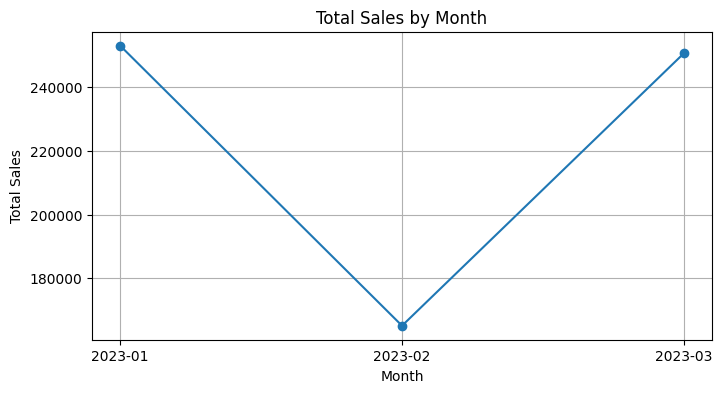

In [30]:
# Prepare data: convert Period to string so matplotlib can plot it easily
sales_by_month_sorted = sales_by_month.sort_index()
months = sales_by_month_sorted.index.astype(str)
values = sales_by_month_sorted.values

plt.figure(figsize=(8, 4))
plt.plot(months, values, marker="o")
plt.title("Total Sales by Month")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()


### Bar Chart: Total Sales by Product Category

Bar charts are great for **comparing categories**.


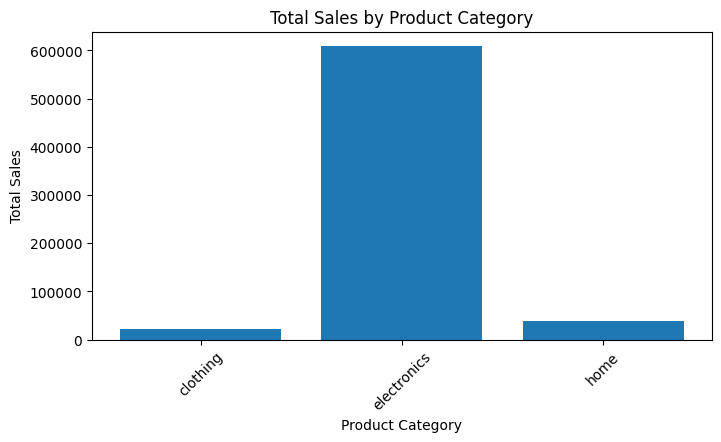

In [31]:
categories = sales_by_category.index
values = sales_by_category.values

plt.figure(figsize=(8, 4))
plt.bar(categories, values)
plt.title("Total Sales by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()


### Pie Chart: Share of Sales by Payment Method

Pie charts can show **proportions** of a whole.
Use them when you want to emphasise parts of a total.


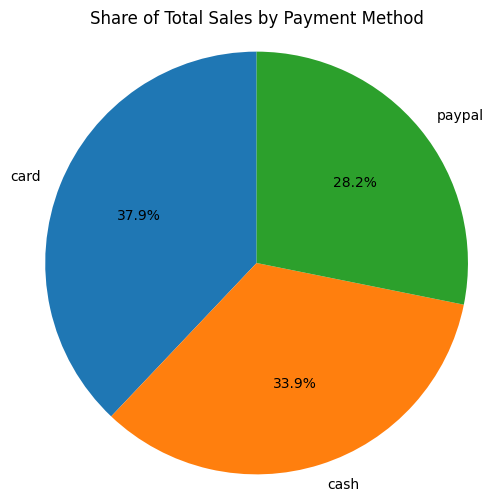

In [32]:
sales_by_payment = df_clean.groupby("payment_method")["total_price"].sum()

labels = sales_by_payment.index
sizes = sales_by_payment.values

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Share of Total Sales by Payment Method")
plt.axis("equal")  # Make the pie chart a circle
plt.show()


### Visualise Outliers with Boxplot



In [ ]:
# ------------------------------------
# Detect outliers using the IQR method
# ------------------------------------

# Choose the column to analyse
col = "quantity"

# Convert to numeric (important if there were strings earlier)
df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# Drop missing values for the calculation
data_no_na = df_clean[col].dropna()

# Step 1: Calculate Q1 and Q3
Q1 = data_no_na.quantile(0.25)
Q3 = data_no_na.quantile(0.75)

# Step 2: Compute IQR
IQR = Q3 - Q1

# Step 3: Determine outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

# Step 4: Identify outliers
outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]

print("\nOutliers detected:")
outliers[[col]].head()


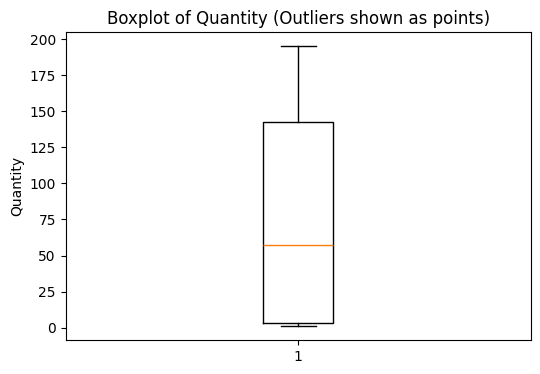

In [38]:
plt.figure(figsize=(6, 4))
plt.boxplot(df_clean[col].dropna())
plt.title("Boxplot of Quantity (Outliers shown as points)")
plt.ylabel("Quantity")
plt.show()


## 7. Summary

In this tutorial, we:

- Created a practical, messy retail dataset
- Inspected the data with:
  - `shape`, `info()`, `head()`, `describe()`, `isna()`
- Cleaned the data:
  - Converted data types (numeric, datetime)
  - Handled missing values (drop + fill)
  - Fixed inconsistent categories with `.str` methods and `.map()`
  - Removed duplicate rows
  - Applied a simple rule to remove outliers
- Engineered a new feature: `total_price`
- Performed EDA with `groupby` and summary statistics
- Created charts using `matplotlib`:
  - Line chart (trend over time)
  - Bar chart (comparison across categories)
  - Pie chart (proportions)
  - Box plot to show outliers
  
You can extend this notebook by:
- Adding more variables (e.g. discount, customer segment)
- Creating more advanced visualisations
- Using libraries such as `seaborn` or `plotly` for richer plots (if allowed)
- Applying statistical tests or building predictive models after EDA
